## Import libraries

In [2]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

# XCLIM and xarray
import numpy as np
import xarray as xr
import dask
from distributed import Client

## 1. Set up Dask client - Parralel processing / workers

In [4]:
# start client
client=Client(n_workers=2, threads_per_worker=12, dashboard_address=8787, memory_limit='10GB')
client

DEBUG:asyncio:Using selector: EpollSelector
DEBUG:asyncio:Using selector: EpollSelector


Client Scheduler: tcp://127.0.0.1:38541 Dashboard: http://127.0.0.1:33910/status,Cluster Workers: 2 Cores: 24 Memory: 20.00 GB


## Ensemble creation & analysis
**Use precalculated annual tx_max index using bias-corrected climate scenarios**

In [5]:
# create dictionary with list of rcp 4.5 and 8.5 files
inrep = '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/'
rcps = ['rcp45','rcp85']
v = 'tx_max'
ncfiles = {}
for r in rcps:
    ncfiles[r] = glob.glob(glob.os.path.join(inrep,r,v,'*.nc'))
print(ncfiles[r])

['/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_ACCESS1-3_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_BNU-ESM_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_CMCC-CMS_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_CanESM2_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_GFDL-ESM2M_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_HadGEM2-CC_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_INM-CM4_rcp

### 1. Create ensemble dataset - concatenation of overlapping time-steps of the different models along a new axis 'realization'

-----
Notes

Input netcdf files require equal spatial dimension size (e.g. lon, lat dimensions) <br />
If input data contains multiple cftime calendar types they must not be at dail frequency

In [6]:
from xclim import ensembles as xens
print('Creating RCP 4.5 ensemble')
ens_rcp45 = xens.create_ensemble(ncfiles['rcp45'])
print('\nCreating RCP 8.5 ensemble')
ens_rcp85 = xens.create_ensemble(ncfiles['rcp85'])

Creating RCP 4.5 ensemble
finding common time-steps
accessing file  1  of  11
accessing file  2  of  11
accessing file  3  of  11
accessing file  4  of  11
accessing file  5  of  11
accessing file  6  of  11
accessing file  7  of  11
accessing file  8  of  11
accessing file  9  of  11
accessing file  10  of  11
accessing file  11  of  11
concatenating files : adding dimension  realization

Creating RCP 8.5 ensemble
finding common time-steps
accessing file  1  of  11
accessing file  2  of  11
accessing file  3  of  11
accessing file  4  of  11
accessing file  5  of  11
accessing file  6  of  11
accessing file  7  of  11
accessing file  8  of  11
accessing file  9  of  11
accessing file  10  of  11
accessing file  11  of  11
concatenating files : adding dimension  realization


### 2. Ensemble data sets have an additional dimension 'realization'

In [7]:
print('RCP 4.5 dataset dimensions: \t', ens_rcp45.tx_max.dims)
print('RCP 4.5 dataset size: \t\t', ens_rcp45.tx_max.shape)

RCP 4.5 dataset dimensions: 	 ('realization', 'time', 'lat', 'lon')
RCP 4.5 dataset size: 		 (11, 151, 180, 324)


### 3. Simple plots
-----
**Time series plot of each simulation : Average of spatial domain ['lon','lat']**

Text(0, 0.5, 'K')

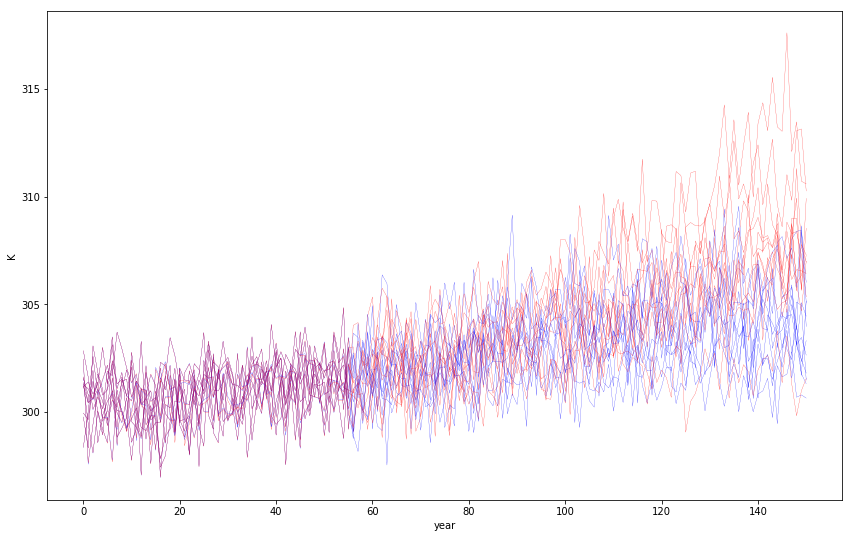

In [8]:
# Plot individual simulations
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
for i in np.arange(0,ens_rcp45[v].shape[0]):
    plt.plot(ens_rcp45[v][i,].mean(['lon','lat']),color='blue',linewidth=0.2)
    plt.plot(ens_rcp85[v][i,].mean(['lon','lat']),color='red',linewidth=0.2)
plt.xlabel('year')
plt.ylabel(ens_rcp45[v].units)

### 4. Ensemble statistics
-----
**Mean, standard-deviation, max, min**

In [9]:
ens_stats = {}
ens_stats['rcp85'] = xens.ensemble_mean_std_max_min(ens_rcp85).chunk(chunks={'time':-1, 'lon':-1, 'lat':-1})
ens_stats['rcp45'] = xens.ensemble_mean_std_max_min(ens_rcp45).chunk(chunks={'time':-1, 'lon':-1, 'lat':-1})
print(ens_stats['rcp85'].data_vars)


Data variables:
    tx_max_mean   (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(151, 180, 324)>
    tx_max_stdev  (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(151, 180, 324)>
    tx_max_max    (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(151, 180, 324)>
    tx_max_min    (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(151, 180, 324)>


Text(0, 0.5, 'K')

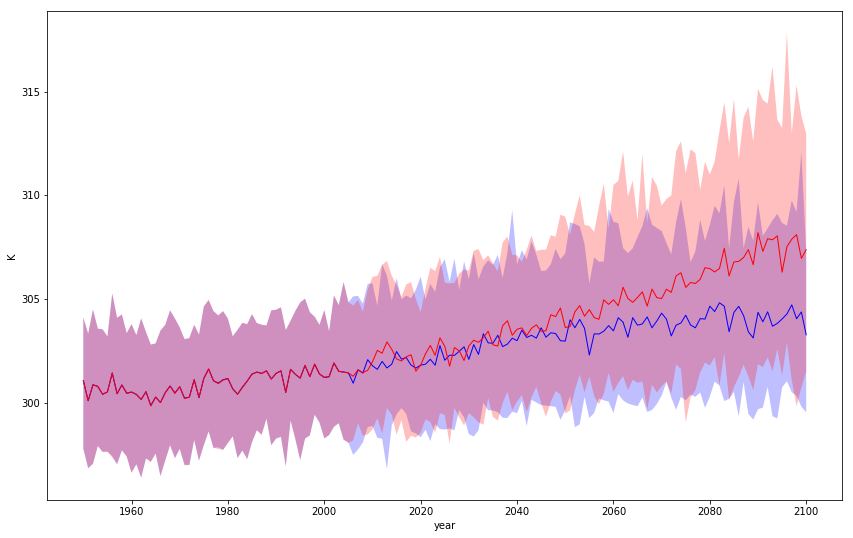

In [10]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
for r in rcps:
    if 'rcp45' in r:
        col1 = 'blue'
    else:
        col1 = 'red'
    # Uncertainty Envelope (max, min)
    x = ens_stats[r]['tx_max_mean'].time.dt.year
    y1 = ens_stats[r]['tx_max_max'].mean(['lon','lat'])
    y2 = ens_stats[r]['tx_max_min'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor = col1, alpha = 0.25)
    
    # Plot ensemble mean
    plt.plot(x,ens_stats[r]['tx_max_mean'].mean(['lon','lat']), color=col1, linewidth = 1)
plt.xlabel('year')
plt.ylabel(ens_rcp45[v].units)

### 4b. Ensemble percentiles
-----
**Percentile calculation (default values : 10th, 50th, 90th)**

In [11]:
ens_perc = {}
ens_perc['rcp85'] = xens.ensemble_percentiles(ens_rcp85)
ens_perc['rcp45'] = xens.ensemble_percentiles(ens_rcp45)
print(ens_perc['rcp85'].data_vars)

#ens_perc = xut.ensemble_percentiles(ens_rcp85, values=[10,25,50,75,90])
#print(ens_perc.data_vars)


loading ensemble data to memory


  interpolation=interpolation)



loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


Text(0, 0.5, 'K')

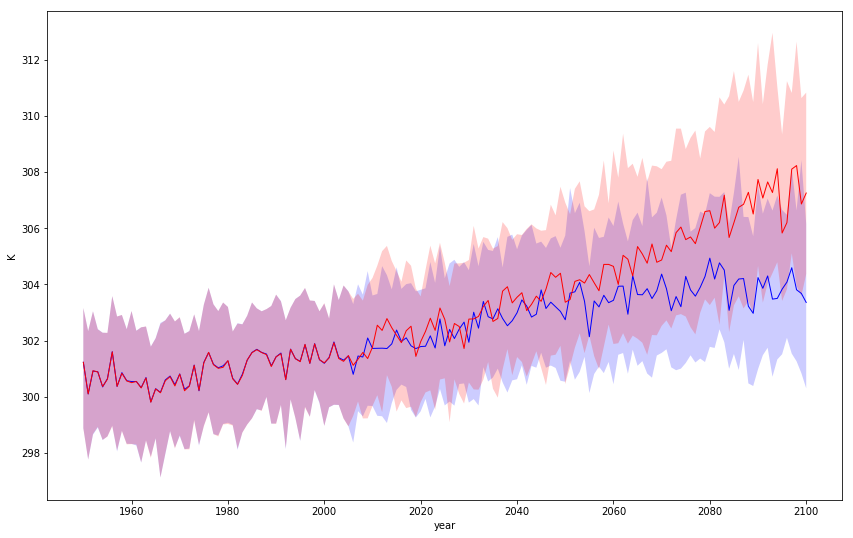

In [12]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]

for r in rcps:
    if 'rcp45' in r:
        col1 = 'blue'
    else:
        col1 = 'red'
        
    #Uncertainty 10-90th band
    y1 = ens_perc[r]['tx_max_p90'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p10'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.2)

    plt.plot(x,ens_perc[r]['tx_max_p50'].mean(['lon','lat']), color=col1, linewidth = 1)
plt.xlabel('year')
plt.ylabel(ens_rcp45[v].units)

**Percentile calculation - custom values**

In [13]:
ens_perc = {}
ens_perc['rcp85'] = xens.ensemble_percentiles(ens_rcp85, values=[10,25,50,75,90])
ens_perc['rcp45'] = xens.ensemble_percentiles(ens_rcp45, values=[10,25,50,75,90])
print(ens_perc['rcp85'].data_vars)

loading ensemble data to memory
loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p25  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p75  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


**Subplot by RCP**

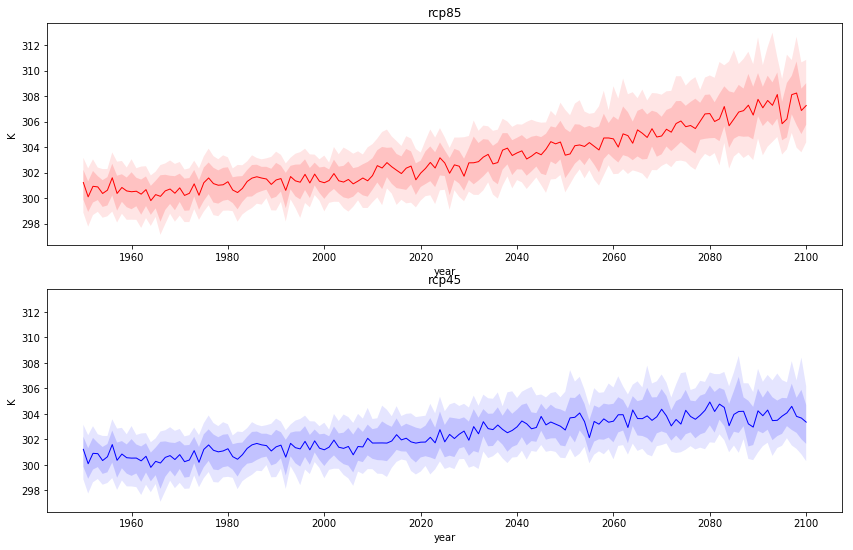

In [14]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
ax = {}
ylim_vals = []
for r in rcps:
    
    if 'rcp45' in r:
        col1 = 'blue'
        ax[r] = plt.subplot(212)
    else:
        col1 = 'red'
        ax[r] = plt.subplot(211)
        
    #Uncertainty 10-90th band
    y1 = ens_perc[r]['tx_max_p90'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p10'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.1)
    
    #Uncertainty 25th-75th band
    y1 = ens_perc[r]['tx_max_p75'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p25'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.15)
    plt.plot(x,ens_perc[r]['tx_max_p50'].mean(['lon','lat']), color=col1, linewidth = 1)
    plt.title(r)
    plt.xlabel('year')
    plt.ylabel(ens_perc[r]['tx_max_p50'].units)
    ylim_vals.extend(ax[r].get_ylim())
    
    

# Adjust y-axis to common values
for r in rcps:
    ax[r].set_ylim(np.min(ylim_vals), np.max(ylim_vals))

### 5. Climatologies and Delta calculations

In [15]:
# 30 year averages
ens30y = ens_rcp85.rolling(time=30,  center=False).mean()
print(ens30y)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, realization: 11, time: 151)
Coordinates:
  * lat      (lat) float64 59.96 59.87 59.79 59.71 ... 45.29 45.21 45.12 45.04
  * lon      (lon) float64 -81.96 -81.88 -81.8 -81.71 ... -55.21 -55.13 -55.05
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
Dimensions without coordinates: realization
Data variables:
    tx_max   (realization, time, lat, lon) float32 nan nan nan ... nan nan nan


-----
Notes - with center==False the output dates represents the end of the moving average

### Map of recent past 1981-2010 for one simulation

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, realization: 11)
Coordinates:
  * lat      (lat) float64 59.96 59.87 59.79 59.71 ... 45.29 45.21 45.12 45.04
  * lon      (lon) float64 -81.96 -81.88 -81.8 -81.71 ... -55.21 -55.13 -55.05
    time     datetime64[ns] 2010-01-01
Dimensions without coordinates: realization
Data variables:
    tx_max   (realization, lat, lon) float32 nan nan nan nan ... nan nan nan nan


Text(0.5, 1.0, '1981-2010 normal')

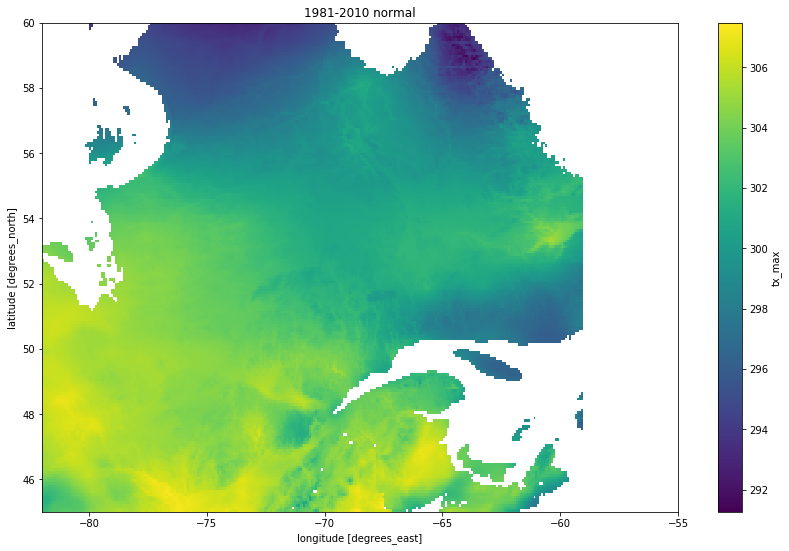

In [16]:
print(ens30y.sel(time='2010-01-01')) 
ens30y.sel(time='2010-01-01')['tx_max'][0,:,:].plot.imshow()
plt.title('1981-2010 normal')

### Calculate delta values  wrt to 1981-2010
**Select reference period**

In [17]:
# select reference period 
ref_per = ens30y.sel(time='2010-01-01')
print(ref_per['tx_max'].dims)
print(ref_per['tx_max'].shape)

('realization', 'lat', 'lon')
(11, 180, 324)


**Calculate delta values for all time-steps**

In [18]:
ensDeltas = ens30y - ref_per
print(ensDeltas)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, realization: 11, time: 151)
Coordinates:
  * lat      (lat) float64 59.96 59.87 59.79 59.71 ... 45.29 45.21 45.12 45.04
  * lon      (lon) float64 -81.96 -81.88 -81.8 -81.71 ... -55.21 -55.13 -55.05
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
Dimensions without coordinates: realization
Data variables:
    tx_max   (realization, time, lat, lon) float32 nan nan nan ... nan nan nan


**Calculate ensemble statistics on 30 year deltas**

In [19]:
ens_percDeltas = xens.ensemble_percentiles(ensDeltas)
print(ens_percDeltas.data_vars)

loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


### Map of ensemble median delta RCP 8.5 : 2071-2100 vs 1981-2010

Text(0.5, 1.0, 'Delta tx_max 2071-2100 versus 1981-2010 : RCP 8.5')

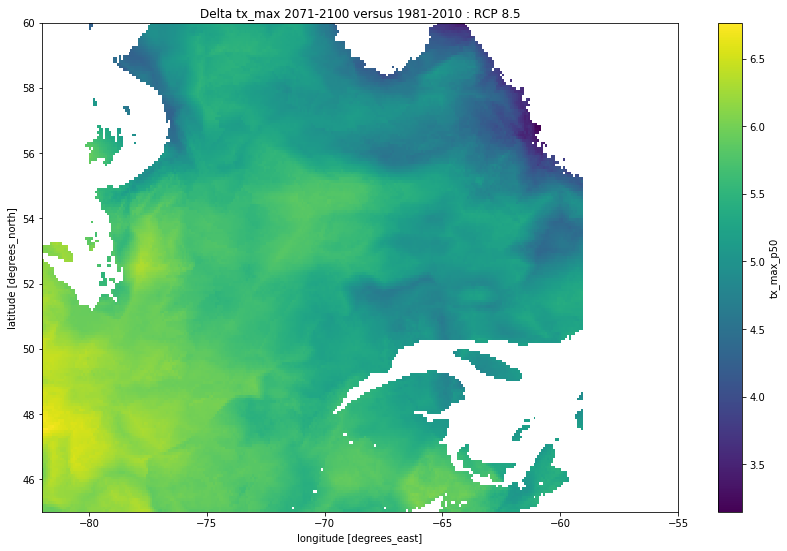

In [20]:
ens_percDeltas['tx_max_p50'].sel(time='2100-01-01').plot.imshow()
plt.title('Delta tx_max 2071-2100 versus 1981-2010 : RCP 8.5')